<a href="https://colab.research.google.com/github/AmirJlr/LLMs/blob/master/Notebooks/05_RAG_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Install necessary packages with a specific version for huggingface_hub to ensure compatibility
!pip install -q langchain langchain-community langchain-google-genai langgraph transformers sentence-transformers huggingface-hub bitsandbytes accelerate faiss-cpu

In [5]:
import os
from langchain.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import HuggingFacePipeline
from langchain.chains import RetrievalQA
from transformers import pipeline

# Simple RAG

In [6]:
### Set hugging face READ access token and store it in colab secrets
from google.colab import userdata
hf_token = userdata.get('HF_TOKEN')

# Securely get the Hugging Face API token
os.environ["HUGGINGFACEHUB_API_TOKEN"] = hf_token
print("Token set successfully!")

Token set successfully!


In [7]:
# Create a directory for our data
!mkdir -p documents

# Create a dummy text file with some notes
file_content = """
Real Madrid named Forbes' most valuable football club in the world for the fourth successive year
Our club tops the list with a value of 6.75 billion dollars, and is the first football team to eclipse 1 billion dollars in revenues.


Real Madrid named Forbes' most valuable football club in the world for the fourth successive year
NEWS.31/05/2025
Real Madrid has been named the most valuable football club in the world for the fourth consecutive year, and the ninth time in the last twelve editions of the list drawn up by Forbes, which values the club at 6.75 billion dollars.
They're followed by Manchester United (6.6 billion dollars). The prestigious publication has released its annual report, which reveals our club's value has risen 2% compared to last year.

Forbes highlights the fact that Real Madrid enjoyed revenues of 1.13 billion dollars in the 2023/24 season, making them the first football team ever to break the 1 billion dollar mark.
The magazine also underlines Real Madrid's Champions League win in 2023/24, as well as the club's international appeal and commercial partnerships.
Furthermore, they highlight how, following the completion of the Santiago Bernabéu, the club expects to increase its matchday revenues, including in ticket sales.


POSITION	                  CLUB	VALUE  IN BILLIONS OF DOLLARS
1	Real Madrid	                         6.75
2	Manchester United	                 6.60
3	F. C. Barcelona	                     5.65
4	Liverpool	                         5.40
5	Manchester City	                     5.30
6	Bayern Munich	                     5.10
7	PSG	                                 4.60
8	Arsenal	                             3.40
9	Tottenham	                         3.30
10	Chelsea	                             3.25
"""

with open("documents/ReadMadrid.txt", "w") as f:
    f.write(file_content)

print("Sample file 'ReadMadrid.txt' created.")

Sample file 'ReadMadrid.txt' created.


## Step 2: Load and Chunk Documents

In [8]:
# 1. Load documents from directory (you can add your text files here)
def load_documents(directory_path="./documents"):
    """Load all text files from directory"""
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"Created {directory_path} directory. Add your text files here!")
        return []

    loader = DirectoryLoader(directory_path, glob="**/*.txt", loader_cls=TextLoader)
    return loader.load()

In [9]:
# 2. Split documents into chunks
def create_chunks(documents):
    """Split documents into smaller chunks for better retrieval"""
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    return text_splitter.split_documents(documents)

## Step 3: Create Vector Embeddings and Store in FAISS

In [10]:
# 3. Create vector store with embeddings
def create_vector_store(chunks):
    """Create FAISS vector store from document chunks"""
    embeddings = HuggingFaceEmbeddings(
        model_name="sentence-transformers/all-MiniLM-L6-v2"
    )
    return FAISS.from_documents(chunks, embeddings)

## Step 4: Create the Q&A Chain

In [11]:
# 4. Setup LLM and QA chain
def setup_qa_chain(vector_store):
    """Setup the question-answering chain"""
    # Use a lightweight model for quick testing
    llm_pipeline = pipeline(
        "text2text-generation",
        model="allenai/unifiedqa-t5-base",
        max_length=512,
        temperature=0.3,
        device_map="auto",
    )
    llm = HuggingFacePipeline(pipeline=llm_pipeline)

    # Create retrieval QA chain
    return RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=vector_store.as_retriever(search_kwargs={"k": 1}),
    )

## Step 5: Main chatbot function

In [12]:
def main():
    print("🧠 Loading your documents...")
    documents = load_documents()

    if not documents:
        print("No documents found! Add .txt files to ./documents directory")
        return

    print("📄 Creating document chunks...")
    chunks = create_chunks(documents)

    print("🔍 Building vector store...")
    vector_store = create_vector_store(chunks)

    print("🤖 Setting up Q&A chain...")
    qa_chain = setup_qa_chain(vector_store)

    print("\n✅ Chatbot ready! Type 'quit' to exit")

    while True:
        question = input("\n❓ Ask a question: ")
        if question.lower() == "quit":
            break

        answer = qa_chain.run(question)
        print(f"🤖 Answer: {answer}")

In [13]:
main()

🧠 Loading your documents...
📄 Creating document chunks...
🔍 Building vector store...


/tmp/ipython-input-10-3198758962.py:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

🤖 Setting up Q&A chain...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Device set to use cpu
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
/tmp/ipython-input-11-1872269798.py:12: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_hugg


✅ Chatbot ready! Type 'quit' to exit

❓ Ask a question: exit


/tmp/ipython-input-12-3058471890.py:25: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  answer = qa_chain.run(question)
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Answer: helpful answer: no

❓ Ask a question: quit


# RAG LangGraph

In [15]:
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings

In [27]:
!pip install pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.6/304.6 kB 4.9 MB/s eta 0:00:00


In [20]:
!pip install -qU langchain-chroma

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 1.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 6.4 MB/s eta 

In [24]:
from typing import TypedDict, Annotated, Sequence

from langgraph.graph import StateGraph, START, END
from operator import add as add_messages

from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_core.tools import tool

import os

In [22]:
llm = ChatGoogleGenerativeAI(model="models/gemini-2.0-flash")
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [31]:
pdf_path = "/content/TacticAI.pdf"

if not os.path.exists(pdf_path):
    raise FileNotFoundError(f"PDF file not found at path: {pdf_path}")

loader = PyPDFLoader(pdf_path)
pages = loader.load()


In [32]:
len(pages)

32

In [33]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
docs = text_splitter.split_documents(pages)

In [34]:
persist_directory = './db'
collection_name = 'tacticAI'

In [36]:
if not os.path.exists(persist_directory):
    os.makedirs(persist_directory)

vector_db = Chroma.from_documents(
    documents=docs,
    embedding=embeddings,
    persist_directory=persist_directory,
    collection_name=collection_name
)

In [37]:
retriever = vector_db.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 3}
)

In [38]:
@tool
def retriever_tool(query: str)->str:
    """
    Search and returns the informationfro TacticAI documentation
    """
    docs = retriever.invoke(query)

    if not docs:
        return "I found no relevant information from TacticAI"

    results = []
    for i, doc in enumerate(docs):
        results.append(f"{i+1}. {doc.page_content}")

    return "\n \n".join(results)


In [39]:
tools = [retriever_tool]

llm = llm.bind_tools(tools)

In [41]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


# conditional edge
def should_continue(state: AgentState):
    """
    Check if the last message contains tool calls
    """
    result = state['messages'][-1]
    return hasattr(result, 'tool_calls') and len(result.tool_calls) > 0

In [42]:
system_prompt = """
You are an intelligent AI assistant who answers questions about TacticAI PDF document loaded into your knowledge base.
Use the retriever tool available to answer questions about the TacticAI data. You can make multiple calls if needed.
If you need to look up some information before asking a follow up question, you are allowed to do that!
Please always cite the specific parts of the documents you use in your answers.
"""

tools_dict = {our_tool.name: our_tool for our_tool in tools}


# LLM Agent
def call_llm(state: AgentState) -> AgentState:
    """Function to call the LLM with the current state."""
    messages = list(state['messages'])
    messages = [SystemMessage(content=system_prompt)] + messages
    message = llm.invoke(messages)
    return {'messages': [message]}


# Retriever Agent
def take_action(state: AgentState) -> AgentState:
    """Execute tool calls from the LLM's response."""

    tool_calls = state['messages'][-1].tool_calls
    results = []
    for t in tool_calls:
        print(f"Calling Tool: {t['name']} with query: {t['args'].get('query', 'No query provided')}")

        if not t['name'] in tools_dict: # Checks if a valid tool is present
            print(f"\nTool: {t['name']} does not exist.")
            result = "Incorrect Tool Name, Please Retry and Select tool from List of Available tools."

        else:
            result = tools_dict[t['name']].invoke(t['args'].get('query', ''))
            print(f"Result length: {len(str(result))}")


        # Appends the Tool Message
        results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))

    print("Tools Execution Complete. Back to the model!")
    return {'messages': results}


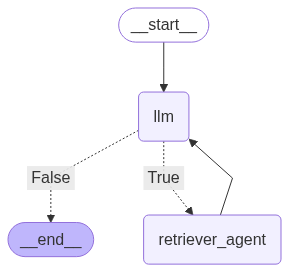

In [43]:
graph = StateGraph(AgentState)


graph.add_node("llm", call_llm)
graph.add_node("retriever_agent", take_action)

graph.add_conditional_edges(
    "llm",
    should_continue,
    {True: "retriever_agent", False: END}
)
graph.add_edge("retriever_agent", "llm")
graph.set_entry_point("llm")

rag_agent = graph.compile()
rag_agent

In [44]:
def running_agent():
    print("\n=== RAG AGENT===")

    while True:
        user_input = input("\nWhat is your question: ")
        if user_input.lower() in ['exit', 'quit']:
            break

        messages = [HumanMessage(content=user_input)] # converts back to a HumanMessage type

        result = rag_agent.invoke({"messages": messages})

        print("\n=== ANSWER ===")
        print(result['messages'][-1].content)


running_agent()


=== RAG AGENT===

What is your question: How GNNs use in football analysis?
Calling Tool: retriever_tool with query: GNNs in football analysis
Result length: 2731
Tools Execution Complete. Back to the model!

=== ANSWER ===
GNNs (Graph Neural Networks) are used in football analysis as a framework for benchmarking various approaches to modeling player-player interactions. The general form of a GNN model can be expressed as:

h(𝑡)𝑢 = 𝜙(h(𝑡−1)𝑢 ,Ê𝑣∈N𝑢 𝜓(h(𝑡−1)𝑢 ,h(𝑡−1)𝑣 ,e𝑣𝑢,g)),

where:

*   𝜓: ℝ𝑘×ℝ𝑘×ℝ𝑙×ℝ𝑚 →ℝ𝑘′ and 𝜙: ℝ𝑘×ℝ𝑘′ →ℝ𝑘′ are learnable functions (e.g., multilayer perceptrons).
*   h(𝑡)𝑢 are the features of node 𝑢 after 𝑡 GNN layers.
*   É is a permutation-invariant aggregator, such as sum, max, or average.
*   h(0)𝑢 = x𝑢, and iterate the equation for 𝑇 steps, where 𝑇 is a hyperparameter.
*   H = 𝑓G(X,E,g)= H(𝑇) is the final node embeddings coming out of the GNN.

This formulation is quite general and can express popular models like Transformers and can be used to model player-pl